In [1]:
import numpy as np
import tensorflow as tf
import scipy as scp
import sklearn as skl
from tqdm import tqdm
import matplotlib.pyplot as plt
import imgaug.augmenters as iaa

In [2]:
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [3]:
X_test.shape

(10000, 28, 28)

In [4]:
X1_train = tf.keras.preprocessing.image.random_rotation(
    X_train,
    30,
    row_axis=1,
    col_axis=2,
    channel_axis=0,
    fill_mode='nearest',
    cval=0.0,
    interpolation_order=1
)

X1_test = tf.keras.preprocessing.image.random_rotation(
    X_test,
    30,
    row_axis=1,
    col_axis=2,
    channel_axis=0,
    fill_mode='nearest',
    cval=0.0,
    interpolation_order=1
)

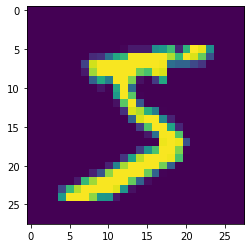

In [7]:
plt.imshow(X_train[0])

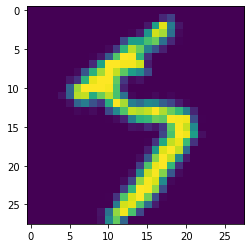

In [8]:
plt.imshow(X1_train[0])

In [9]:
X1_test.shape

(10000, 28, 28)

In [10]:
X_train = X_train.reshape(-1, 784).astype("float32") / 255.0
X1_train = X1_train.reshape(-1, 784).astype("float32") / 255.0
X_test = X_test.reshape(-1, 784).astype("float32") / 255.0
X1_test = X1_test.reshape(-1, 784).astype("float32") / 255.0


In [11]:
def tf_unif_prior_crossentropy(pred1,pred2):
    N, C = pred1.shape 
    
    t_c = 0.1
    t_r = 0.1
    
    a = tf.nn.softmax(pred2/t_c, axis=0)
    b = tf.linalg.norm(a, ord=1,axis=1)
    c = a/tf.reshape(b,(N,-1))
    part11 = c
    d = tf.nn.softmax(pred1/t_r, axis=1)
    part21 = tf.reshape(tf.math.log(N/C *d/tf.linalg.norm(d, ord=1, axis=0)), (-1,C))
    loss_1 = -tf.math.reduce_sum( part11 * part21 , axis=-1)
    
    a = tf.nn.softmax(pred1/t_c)
    b = tf.linalg.norm(a, ord=1,axis=1)
    c = a/tf.reshape(b,(N,-1))
    part12 = c
    d = tf.nn.softmax(pred2/t_r, axis=1)
    part22 = tf.reshape(tf.math.log(N/C *d/tf.linalg.norm(d, ord=1, axis=0)),(-1,C))
    loss_2 = -tf.math.reduce_sum( part12*part22 , axis=-1)

    return tf.math.reduce_mean(1/2*(loss_1+loss_2))


In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(28*28), dtype=tf.float32),
    tf.keras.layers.Dense(units=256, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(units=128, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10,activation = None, dtype='float32'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("softmax")
    ])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               200960    
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                                 
 batch_normalization_2 (Batc  (None, 10)               4

In [14]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

NUM_EPOCHS = 10
EPOCH_PER_DISPLAY = 1
total_loss = []
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, X1_train))
train_dataset = train_dataset.shuffle(X_train.shape[0]).batch(1000)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, X1_test))
test_dataset = test_dataset.shuffle(X_test.shape[0]).batch(10)

for epoch in range(NUM_EPOCHS):

  running_loss = []
  valid_loss = []

  for input1, input2 in tqdm(train_dataset):
    with tf.GradientTape() as tape:

      pred1 = model(input1, training=True)
      pred2 = model(input2, training=True)

      loss_ = tf_unif_prior_crossentropy(pred1, pred2)

      grads = tape.gradient(loss_, model.trainable_variables)
      
    running_loss.append(loss_)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
  
  epoch_loss = np.mean(running_loss)
  if (epoch + 1) % EPOCH_PER_DISPLAY == 0:
    print("Epoch {}: Loss: {:.4f}".format(epoch+1, epoch_loss), end="")
  for input1, input2 in train_dataset:
    pred1 = model(input1, training=False)
    pred2 = model(input2, training=False)
    loss_ = tf_unif_prior_crossentropy(pred1, pred2)
    valid_loss.append(loss_)
    pred1 = pred1.numpy().argmax(axis=1)
    pred2 = pred2.numpy().argmax(axis=1)
    cor_cnt = 0
    for tmp1, tmp2 in zip(pred1, pred2):
      if (tmp1 == tmp2):
        cor_cnt += 1
  print("    Valid Loss: {:.4f}   Correct: {}".format(np.mean(valid_loss), cor_cnt))

100%|██████████| 60/60 [00:10<00:00,  5.60it/s]


Epoch 1: Loss: 1.1191    Valid Loss: 1.7274   Correct: 861


100%|██████████| 60/60 [00:08<00:00,  6.95it/s]


Epoch 2: Loss: 0.5092    Valid Loss: 0.9471   Correct: 933


100%|██████████| 60/60 [00:07<00:00,  7.79it/s]


Epoch 3: Loss: 0.3589    Valid Loss: 0.5305   Correct: 940


100%|██████████| 60/60 [00:10<00:00,  5.85it/s]


Epoch 4: Loss: 0.2811    Valid Loss: 0.3791   Correct: 948


100%|██████████| 60/60 [00:10<00:00,  5.87it/s]


Epoch 5: Loss: 0.2306    Valid Loss: 0.3182   Correct: 952


100%|██████████| 60/60 [00:10<00:00,  5.87it/s]


Epoch 6: Loss: 0.1995    Valid Loss: 0.2864   Correct: 954


100%|██████████| 60/60 [00:07<00:00,  7.92it/s]


Epoch 7: Loss: 0.1743    Valid Loss: 0.2675   Correct: 960


100%|██████████| 60/60 [00:08<00:00,  7.42it/s]


Epoch 8: Loss: 0.1545    Valid Loss: 0.2727   Correct: 956


100%|██████████| 60/60 [00:10<00:00,  5.87it/s]


Epoch 9: Loss: 0.1441    Valid Loss: 0.2719   Correct: 953


100%|██████████| 60/60 [00:10<00:00,  5.87it/s]


Epoch 10: Loss: 0.1346    Valid Loss: 0.2506   Correct: 946
